# Generates images from text prompts with CLIP guided diffusion.

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). It uses either OpenAI's 256x256 unconditional ImageNet or Katherine Crowson's fine-tuned 512x512 diffusion model (https://github.com/openai/guided-diffusion), together with CLIP (https://github.com/openai/CLIP) to connect text prompts with images.

Modified by Daniel Russell (https://github.com/russelldc, https://twitter.com/danielrussruss) to include (hopefully) optimal params for quick generations in 15-100 timesteps rather than 1000, as well as more robust augmentations.

**Update**: Sep 19th 2021


Further improvements from Dango233 and nsheppard helped improve the quality of diffusion in general, and especially so for shorter runs like this notebook aims to achieve.

Katherine's original notebook can be found here:
https://colab.research.google.com/drive/1QBsaDAZv8np29FPbvjffbE1eytoJcsgA

Vark has added some code to load in multiple Clip models at once, which all prompts are evaluated against, which may greatly improve accuracy.

I, pbaylies, have added some code to augment a CLIP model, which may also improve the results.

In [1]:
import torch
# Check the GPU status
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
!nvidia-smi

Using device: cuda:0
Sat Mar 12 01:00:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 69%   42C    P5    43W / 250W |   1084MiB / 11011MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                   

In [2]:
#@title Choose model here:
diffusion_model = "256x256_diffusion_uncond" #@param ["256x256_diffusion_uncond", "512x512_diffusion_uncond_finetune_008100"]
#@markdown If you connect your Google Drive, you can save the final image of each run on your drive.

google_drive = False #@param {type:"boolean"}

#@markdown You can use your mounted Google Drive to load the model checkpoint file if you've already got a copy downloaded there. This will save time (and resources!) when you re-visit this notebook in the future.

#@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
yes_please = False #@param {type:"boolean"}

In [3]:
#@title Download diffusion model

import os
model_path = os.getcwd() + '/'
if google_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    if yes_please:
        model_path = '/content/drive/MyDrive/' 

if diffusion_model == '256x256_diffusion_uncond':
    !wget --continue 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt' -P {model_path}
elif diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    !wget --continue 'https://the-eye.eu/public/AI/models/512x512_diffusion_unconditional_ImageNet/512x512_diffusion_uncond_finetune_008100.pt' -P {model_path}

if google_drive and not yes_please:
    model_path = '/content/drive/MyDrive/' 
try:
    os.mkdir(model_path + 'image_storage')
except:
    pass

--2022-03-12 01:00:24--  https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.60.241.33
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.60.241.33|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.



# Install and import dependencies

In [4]:
!git clone https://github.com/openai/CLIP
!git clone https://github.com/crowsonkb/guided-diffusion
!pip3.8 install -e ./CLIP
!pip3.8 install -e ./guided-diffusion
!pip3.8 install lpips datetime

fatal: destination path 'CLIP' already exists and is not an empty directory.
fatal: destination path 'guided-diffusion' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///home/pb/pytorch/Augmented_CLIP/CLIP
  Preparing metadata (setup.py) ... done
  Attempting uninstall: clip
    Found existing installation: clip 1.0
    Uninstalling clip-1.0:
      Successfully uninstalled clip-1.0
  Running setup.py develop for clip
You should consider upgrading via the '/opt/intel/oneapi/intelpython/latest/envs/stylegan3/bin/python3 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///home/pb/pytorch/Augmented_CLIP/guided-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: guided-diffusion
    Found existing installation: guided-diffusion 0.0.0
    Uninstalling guided-diffusion-0.0.0:
      Successfully uninstalled g

In [5]:
import gc
import io
import math
import sys
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')
import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random

# Define necessary functions

In [6]:
# https://gist.github.com/adefossez/0646dbe9ed4005480a2407c62aac8869

def interp(t):
    return 3 * t**2 - 2 * t ** 3

def perlin(width, height, scale=10, device=None):
    gx, gy = torch.randn(2, width + 1, height + 1, 1, 1, device=device)
    xs = torch.linspace(0, 1, scale + 1)[:-1, None].to(device)
    ys = torch.linspace(0, 1, scale + 1)[None, :-1].to(device)
    wx = 1 - interp(xs)
    wy = 1 - interp(ys)
    dots = 0
    dots += wx * wy * (gx[:-1, :-1] * xs + gy[:-1, :-1] * ys)
    dots += (1 - wx) * wy * (-gx[1:, :-1] * (1 - xs) + gy[1:, :-1] * ys)
    dots += wx * (1 - wy) * (gx[:-1, 1:] * xs - gy[:-1, 1:] * (1 - ys))
    dots += (1 - wx) * (1 - wy) * (-gx[1:, 1:] * (1 - xs) - gy[1:, 1:] * (1 - ys))
    return dots.permute(0, 2, 1, 3).contiguous().view(width * scale, height * scale)

def perlin_ms(octaves, width, height, grayscale, device=device):
    out_array = [0.5] if grayscale else [0.5, 0.5, 0.5]
    # out_array = [0.0] if grayscale else [0.0, 0.0, 0.0]
    for i in range(1 if grayscale else 3):
        scale = 2 ** len(octaves)
        oct_width = width
        oct_height = height
        for oct in octaves:
            p = perlin(oct_width, oct_height, scale, device)
            out_array[i] += p * oct
            scale //= 2
            oct_width *= 2
            oct_height *= 2
    return torch.cat(out_array)

def create_perlin_noise(octaves=[1, 1, 1, 1], width=2, height=2, grayscale=True):
    out = perlin_ms(octaves, width, height, grayscale)
    if grayscale:
        out = TF.resize(size=(side_x, side_y), img=out.unsqueeze(0))
        out = TF.to_pil_image(out.clamp(0, 1)).convert('RGB')
    else:
        out = out.reshape(-1, 3, out.shape[0]//3, out.shape[1])
        out = TF.resize(size=(side_x, side_y), img=out)
        out = TF.to_pil_image(out.clamp(0, 1).squeeze())

    out = ImageOps.autocontrast(out)
    return out

In [7]:
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()

def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.reshape([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.reshape([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, skip_augs=False):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.skip_augs = skip_augs
        self.augs = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomPerspective(distortion_scale=0.4, p=0.7),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomGrayscale(p=0.15),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        ])

    def forward(self, input):
        input = T.Pad(input.shape[2]//4, fill=0)(input)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)

        cutouts = []
        for ch in range(cutn):
            if ch > cutn - cutn//4:
                cutout = input.clone()
            else:
                size = int(max_size * torch.zeros(1,).normal_(mean=.8, std=.3).clip(float(self.cut_size/max_size), 1.))
                offsetx = torch.randint(0, abs(sideX - size + 1), ())
                offsety = torch.randint(0, abs(sideY - size + 1), ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]

            if not self.skip_augs:
                cutout = self.augs(cutout)
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
            del cutout

        cutouts = torch.cat(cutouts, dim=0)
        return cutouts


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

def unitwise_norm(x, norm_type=2.0):
    if x.ndim <= 1:
        return x.norm(norm_type)
    else:
        # works for nn.ConvNd and nn,Linear where output dim is first in the kernel/weight tensor
        # might need special cases for other weights (possibly MHA) where this may not be true
        return x.norm(norm_type, dim=tuple(range(1, x.ndim)), keepdim=True)

def adaptive_clip_grad(parameters, clip_factor=0.01, eps=1e-3, norm_type=2.0, rand=0.02):
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    for p in parameters:
        if p.grad is None:
            continue
        p_data = p.detach()
        g_data = p.grad.detach()
        max_norm = unitwise_norm(p_data, norm_type=norm_type).clamp_(min=eps).mul_(clip_factor)
        grad_norm = unitwise_norm(g_data, norm_type=norm_type)
        # add stochastic gradient clipping
        #clipped_grad = g_data * (((max_norm * torch.rand_like(g_data)).clamp_(min=1e-6)) / grad_norm.clamp(min=1e-6))
        # add noise
        #clipped_grad = g_data * (max_norm / grad_norm.clamp(min=1e-6)) + (max_norm / 50.0) * torch.randn_like(g_data)
        # do both?
        #clipped_grad = g_data * (((max_norm * torch.rand_like(g_data)).clamp_(min=1e-6)) / grad_norm.clamp(min=1e-6)) + (max_norm / 100.0) * torch.randn_like(g_data)
        if rand > 0.0:
            clipped_grad = g_data * (max_norm / grad_norm.clamp(min=1e-6)) + (rand*max_norm) * torch.randn_like(g_data)
        else:
            clipped_grad = g_data * (max_norm / grad_norm.clamp(min=1e-6))
        #new_grads = torch.where(grad_norm < max_norm, g_data + (max_norm / 30.0) * torch.randn_like(g_data), clipped_grad)
        new_grads = torch.where(grad_norm < max_norm, g_data, clipped_grad)
        p.grad.detach().copy_(new_grads)

In [8]:
def do_run():
    loss_values = []
    final_values = []
    images = []
 
    target_embeds, weights = [], []
    model_stats = []
    first = True

    for clip_model in clip_models:
        model_stat = {"clip_model":None,"target_embeds":[],"make_cutouts":None,"weights":[]}
        model_stat["clip_model"] = clip_model
        model_stat["make_cutouts"] = MakeCutouts(clip_model.visual.input_resolution, cutn, skip_augs=skip_augs)
        for prompt in text_prompts:
            txt, weight = parse_prompt(prompt)
            txt = clip_model.encode_text(clip.tokenize(prompt, truncate=True).to(device)).float()
            
            # normalize and weighted average with augmented embeddings below
            with torch.no_grad():
                orig_txt = txt.clone()
                if first:
                    txts = []
                    for i in range(0, num_models):
                        txt = orig_txt.clone()
                        for j in range(0, model_depth):
                            first_txt = txt.clone()
                            (std1, mean1) = torch.std_mean(txt)
                            txt = text_to_images[i](txt)
                            (std2, mean2) = torch.std_mean(txt)
                            txt = mean1+std1*((txt-mean2)/(std2))
                            txt0 = txt.clone()
                            (std1, mean1) = torch.std_mean(txt)
                            txt = image_to_texts[i](txt)
                            (std2, mean2) = torch.std_mean(txt)
                            txt = mean1+std1*((txt-mean2)/(std2))
                            txt = 0.25*orig_txt+0.25*first_txt+0.25*txt+0.25*txt0
                            if (random.randint(0, model_avg_freq) == 0 and len(txts) > 0):
                                txt = 0.5*txt + txts[-random.randint(0, j)]
                            txts.append(txt.clone())
                else:
                    txts = [orig_txt]
                
            if fuzzy_prompt:
                for i in range(25):
                    for txt in txts:
                        model_stat["target_embeds"].append((txt + torch.randn(txt.shape).cuda() * rand_mag).clamp(0,1))
                        model_stat["weights"].append(weight)
            else:
                for txt in txts:
                    model_stat["target_embeds"].append(txt)
                    model_stat["weights"].append(weight)
                
        for prompt in image_prompts:
            path, weight = parse_prompt(prompt)
            img = Image.open(fetch(path)).convert('RGB')
            img = TF.resize(img, min(side_x, side_y, *img.size), Image.LANCZOS)
            batch = model_stat["make_cutouts"](TF.to_tensor(img).to(device).unsqueeze(0).mul(2).sub(1))
            embed = clip_model.encode_image(normalize(batch)).float()
            if fuzzy_prompt:
                for i in range(25):
                    model_stat["target_embeds"].append((embed + torch.randn(embed.shape).cuda() * rand_mag).clamp(0,1))
                    weights.extend([weight / cutn] * cutn)
            else:
                model_stat["target_embeds"].append(embed)
                model_stat["weights"].extend([weight / cutn] * cutn)
    
        model_stat["target_embeds"] = torch.cat(model_stat["target_embeds"])
        model_stat["weights"] = torch.tensor(model_stat["weights"], device=device)
        if model_stat["weights"].sum().abs() < 1e-3:
            raise RuntimeError('The weights must not sum to 0.')
        model_stat["weights"] /= model_stat["weights"].sum().abs()
        model_stats.append(model_stat)
        first = False

 
    init = None
    if init_image is not None:
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)
    
    if perlin_init:
        if perlin_mode == 'color':
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
        elif perlin_mode == 'gray':
           init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
           init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
        else:
           init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
           init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
        
        init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
        del init2
 
    cur_t = None
 
    def cond_fn(x, t, y=None):
        with torch.enable_grad():
            x = x.detach().requires_grad_()
            n = x.shape[0]
            my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
            out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
            fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
            x_in = out['pred_xstart'] * fac + x * (1 - fac)
            x_in_grad = torch.zeros_like(x_in)

            for model_stat in model_stats:
              for i in range(cutn_batches):
                  clip_in = normalize(model_stat["make_cutouts"](x_in.add(1).div(2)))
                  image_embeds = model_stat["clip_model"].encode_image(clip_in).float()
                  dists = spherical_dist_loss(image_embeds.unsqueeze(1), model_stat["target_embeds"].unsqueeze(0))
                  dists = dists.view([cutn, n, -1])
                  losses = dists.mul(model_stat["weights"]).sum(2).mean(0)
                  loss_values.append(losses.sum().item()) # log loss, probably shouldn't do per cutn_batch
                  x_in_grad += torch.autograd.grad(losses.sum() * clip_guidance_scale, x_in)[0] / cutn_batches
            tv_losses = tv_loss(x_in)
            range_losses = range_loss(out['pred_xstart'])
            sat_losses = torch.abs(x_in - x_in.clamp(min=-1,max=1)).mean()
            loss = tv_losses.sum() * tv_scale + range_losses.sum() * range_scale + sat_losses.sum() * sat_scale
            if init is not None and init_scale:
                init_losses = lpips_model(x_in, init)
                loss = loss + init_losses.sum() * init_scale
            x_in_grad += torch.autograd.grad(loss, x_in)[0]
            grad = -torch.autograd.grad(x_in, x, x_in_grad)[0]
        if clamp_grad:
            adaptive_clip_grad([x], rand=1.0)
            magnitude = grad.square().mean().sqrt()
            return grad * magnitude.clamp(max=0.05) / magnitude
        return grad
 
    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive
 
    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1
 
        if model_config['timestep_respacing'].startswith('ddim'):
            samples = sample_fn(
                model,
                (batch_size, 3, side_y, side_x),
                clip_denoised=clip_denoised,
                model_kwargs={},
                cond_fn=cond_fn,
                progress=True,
                skip_timesteps=skip_timesteps,
                init_image=init,
                randomize_class=randomize_class,
                eta=eta,
            )
        else:
            samples = sample_fn(
                model,
                (batch_size, 3, side_y, side_x),
                clip_denoised=clip_denoised,
                model_kwargs={},
                cond_fn=cond_fn,
                progress=True,
                skip_timesteps=skip_timesteps,
                init_image=init,
                randomize_class=randomize_class,
            )

        for j, sample in enumerate(samples):
            cur_t -= 1
            if j % display_rate == 0 or cur_t == -1:
                display.clear_output(wait=True)
                for k, image in enumerate(sample['pred_xstart']):
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
                    filename = f'progress_batch{i:05}_iteration{j:05}_output{k:05}_{current_time}.png'
                    image = TF.to_pil_image(image.add(1).div(2).clamp(0, 1))
                    #image.save(model_path + filename)
                    display.display(image)
                    if cur_t == -1:
                        fpath = model_path + 'image_storage/' + filename
                        image.save(fpath)
                        final_values.append(loss_values[-1])
                        images.append(fpath)
 
        plt.plot(np.array(loss_values), 'r')
    return (final_values, images)

# Load Diffusion and CLIP models

In [9]:
timestep_respacing = 'ddim200' # Modify this value to change the number of timesteps.
diffusion_steps = 1000

model_config = model_and_diffusion_defaults()
if diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == '256x256_diffusion_uncond':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })
side_x = side_y = model_config['image_size']

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(f'{model_path}{diffusion_model}.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

In [10]:
#clip_models = [clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device),clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device),clip.load('RN50x4', jit=False)[0].eval().requires_grad_(False).to(device)]
#clip_models = [clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)]
clip_models = [clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device),clip.load('ViT-L/14', jit=False)[0].eval().requires_grad_(False).to(device)]


normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
#lpips_model = lpips.LPIPS(net='vgg').to(device)
#AlexNet model also works fine for less RAM usage
lpips_model = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/intel/oneapi/intelpython/latest/envs/stylegan3/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


# Settings

In [19]:
_project_name = 'painting' #@param{type:"string"}
_text_prompt = "Stunning landscape painting in spring, by Claude Monet"
_text_prompt1 = "Photorealistic proportional and well-composed portrait painting of a beautiful young lady, pretty face, by van Gogh"
_text_prompt2 = "An aesthetically beautiful picture of a young lady at the park, trending on Instagram"

# Feel free to use multiple prompts!
text_prompts = [
    _text_prompt,
    _text_prompt1,
    _text_prompt2,
]

image_prompts = [
    #'mona.jpg',
]

# 350/50/50/32 and 500/0/0/64 have worked well for 25 timesteps on 256px
# Also, sometimes 1 cutn actually works out fine

clip_guidance_scale = 10000 # 1000 - Controls how much the image should look like the prompt.
tv_scale = 150 # 150 - Controls the smoothness of the final output.
range_scale = 150 # 150 - Controls how far out of range RGB values are allowed to be.
sat_scale = 0 # 0 - Controls how much saturation is allowed. From nshepperd's JAX notebook.
cutn = 4 # 16 - Controls how many crops to take from the image.
cutn_batches = 1 # 2 - Accumulate CLIP gradient from multiple batches of cuts [Can help with OOM errors / Low VRAM]

#init_image = 'mona_256.png' # None - URL or local path
init_image = None
init_scale = 0 # 0 - This enhances the effect of the init image, a good value is 1000
skip_timesteps = 0 # 0 - Controls the starting point along the diffusion timesteps
perlin_init = False # False - Option to start with random perlin noise
perlin_mode = 'gray' # 'mixed' ('gray', 'color')

skip_augs = False # False - Controls whether to skip torchvision augmentations
randomize_class = True # True - Controls whether the imagenet class is randomly changed each iteration
clip_denoised = False # False - Determines whether CLIP discriminates a noisy or denoised image
clamp_grad = True # True - Experimental: Using adaptive clip grad in the cond_fn

fuzzy_prompt = False # False - Controls whether to add multiple noisy prompts to the prompt losses
rand_mag = 1.0 # 0.1 - Controls the magnitude of the random noise
eta = 1.0 # 0.0 - DDIM hyperparameter

seed = random.randint(0, 2**32) # Choose a random seed and print it at end of run for reproduction
#seed = 2547079922
if seed is not None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


## Diffuse!

Batch 0, step 199, output 0:


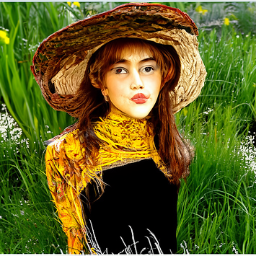

  0%|          | 0/200 [00:00<?, ?it/s]

seed 2547079922


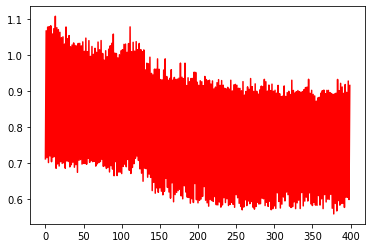

In [20]:
display_rate = 20
n_batches = 4 # 1 - Controls how many consecutive batches of images are generated
batch_size = 1 # 1 - Controls how many images are generated in parallel in a batch
gc.collect()
torch.cuda.empty_cache()
best_losses = []
best_images = []
best_images_log = []
ls_run = []
im_run = []
model_used_log = []
aug_model_path = 'checkpoints/'
#aug_models = ["_media","_sampo","_nothing2","s1","s2","s3"]
aug_models = ["_avg1"]
num_models = 1
model_depth = 500
model_avg_freq = 10
start = True
try:
    while True:
        if start or random.randint(0, len(aug_models)-1) == 0:
            text_to_images = []
            image_to_texts = []
            pick_models = np.random.choice(aug_models, size=[num_models], replace=False)
            print(pick_models)
            model_used_log.append(pick_models)
            for pm in pick_models:
                text_to_image = torch.load(aug_model_path + "t2i" + pm + ".pt")
                text_to_image.requires_grad_(False).eval().to(device)
                image_to_text = torch.load(aug_model_path + "i2t" + pm + ".pt")
                image_to_text.requires_grad_(False).eval().to(device)
                text_to_images.append(text_to_image)
                image_to_texts.append(image_to_text)
            start = False
        (ls_run, im_run) = do_run()
        best_losses = best_losses + ls_run
        best_images = best_images + im_run
        init_scale = 0
        skip_timesteps = random.randint(40, 100)
        seed = random.randint(0, 2**32)
        best_indexes = np.argpartition(np.array(best_losses), kth=2)[0:3]
        random.shuffle(best_indexes)
        best_losses = list(np.array(best_losses)[best_indexes][0:3])
        best_images = list(np.array(best_images)[best_indexes][0:3])
        init_image = best_images[random.randint(0, 2)]
        best_images_log.append(init_image)
except KeyboardInterrupt:
    pass
finally:
    print('seed', seed)
    gc.collect()
    torch.cuda.empty_cache()